# Lab 2

##### Team Members: Alex Lopez, Chris Haub, Erin McClure-Price

In [93]:
# Importing all packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
import glob
import os
import seaborn as sns #may not use
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Suppress futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Suppress convergence warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

#Set Figure Size
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
## setting up function to create confusion matrix
def make_confusion_matrix(model,y_actual, x_test, labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(x_test)
    cm=mt.confusion_matrix( y_actual, y_predict, labels=labels)
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X



   '''
    # defining an empty list to store train and test results
    score_list=[]
    
    #Predicting on train and tests
    pred_train = model.predict(xTrainScaled)
    pred_test = model.predict(xTestScaled)
    
    #Accuracy of the model
    train_acc = model.score(xTrainScaled,yTrain)
    test_acc = model.score(xTestScaled,yTest)
    
    #Recall of the model
    train_recall = mt.recall_score(yTrain,pred_train,pos_label="no")
    test_recall = mt.recall_score(yTest,pred_test,pos_label="no")
    
    #Precision of the model
    train_precision = mt.precision_score(yTrain,pred_train,pos_label="no")
    test_precision = mt.precision_score(yTest,pred_test,pos_label="no")

    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ",model.score(xTrainScaled,yTrain))
        print("Accuracy on test set : ",model.score(xTestScaled,yTest))
        print("\nRecall on training set : ",mt.recall_score(yTrain,pred_train,pos_label="no"))
        print("Recall on test set : ",mt.recall_score(yTest,pred_test,pos_label="no"))
        print("\nPrecision on training set : ",mt.precision_score(yTrain,pred_train,pos_label="no"))
        print("Precision on test set : ",mt.precision_score(yTest,pred_test,pos_label="no"))
    
    return score_list # returning the list with train and test scores

## Data Preparation

### Part 1

***Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.***

The first step was to load necessary packages and the dataset. In addition, we created a series of variables for indexing both the continuous and categorical variables.

In [4]:
#Import Dataset from github repo
bankData = pd.read_csv('bank-additional-full.csv', sep=';', na_values="unknown")
#Optional: Add in index column
#bankData.insert(0, 'Sample_ID', range(1,len(bankData)+1))

#Creating variables for indexing continuous and categorical variables
conCol = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
          'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

catCol = ['job', 'marital', 'education', 'housing', 'loan', 
          'contact', 'month', 'day_of_week', 'poutcome'] # Default is removed from this list because it is not used 

The next step was to drop entries with missing values, this removed 10,701 rows leaving 30,488 rows which, as discussed in previous assignments, was sufficient for the analysis requirements. In addition, we removed the 'default' column due to its consisting of almost entirely 'no' responses with a total of 3 'yes' responses.

In [5]:
bankData2 = bankData.dropna()
#Remove 'default' column
bankData2 = bankData2.drop(['default'], axis=1)
bankData2.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Double checking the shape of the data showed that we had, indeed, a total of 30,488 rows and 20 attributes in our cleaned dataset.

In [6]:
bankData2.shape

(30488, 20)

We looked at the simple statistics of the continuous variables and noted that the means were close to the median, indicating that their distributions were fairly symmetrical and would not require any mathematical treatments prior to analysis.

In [7]:
#Getting basic statistical overview of continuous variables using the describe function
bankData2.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000
mean,39.030012,259.484092,2.521451,956.332295,0.194273,-0.071510,93.523311,-40.602263,3.459938,5160.813409
std,10.333529,261.714262,2.720150,201.373292,0.522788,1.610399,0.585374,4.789249,1.777231,75.158065
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,31.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.313000,5099.100000
50%,37.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.444000,-41.800000,4.856000,5191.000000
75%,45.000000,321.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,95.000000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Looking at the target variable, y, we see that it is remarkably unbalanced with over 25,000 "no" responses and less than 5,000 "yes" responses. While we could balance the target variable to even out the responses, we felt that increasing the "yes" answers would bias the outcomes of the models. Since the "no" responses are real we chose not to balance the variable in order to obtain more realistic models.

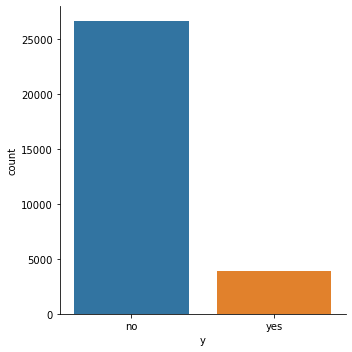

In [8]:
sns.catplot(x='y', data = bankData2, kind = 'count')

Our second target variable, education, consists of seven levels: illiterate, basic 4, 6, and 9 years, highschool, university degree, and professional course. We noted that the majority of customers had a university degree (34%), followed by highschool (25%). The basic 9 year (14%) and professional course (14.1%) were fairly close followed by basic 4 year (8%) and then basic 6 year (5%). The illitterate level was 0.0004%. 

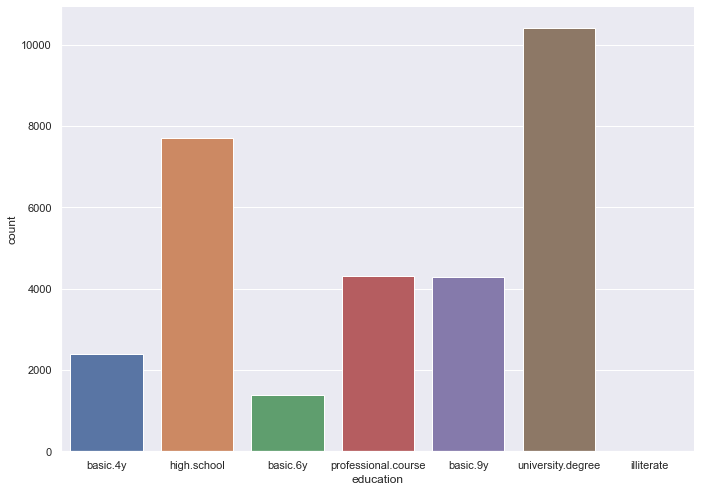

In [96]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.catplot(x='education', data = bankData2, kind = 'count', height=7, aspect=11.7/8.27)

The code below returns the counts and percentages of each level in the categorical variables. For jobs, most customers are in admin (28%) followed by blue-collar (19%) and technician (18%). The marital status for the majority of customers is married (57%), followed by single (31%), and divorced (12%). There were more customers with university degrees (34%) than all other levels of education, while the those customers who had housing loans (54%) were close to those without housing loans (46%).

From looking at the loan variable, we noted that only 16% of customers had taken out a personal loan, and from the contact variable we saw that the majority of customers used cellphones (67%) over telephones.

Interestingly, significantly more customers were contacted in the month of May (32%) than any other month, though we cannot make any inferences about why this would be the case since it is likely due to the bank's protocols. The day of the week did not appear to have any influence on customer count, while the variable for outcome of the previous marketing campaign, poutcome, did show that the majority of customers had nonexistent outcomes (85%).


In [9]:
def getCP(column):
    xCount = column.value_counts()
    xPercentages = xCount/len(column)
    outData = pd.DataFrame()
    outData['Counts'] = xCount
    outData['Percent of Total'] = xPercentages
    return outData

for i in catCol:
    print("Percentages for ",i," : \n",getCP(bankData2[i]),"\n\n")

Percentages for  job  : 
                Counts  Percent of Total
admin.           8737          0.286572
blue-collar      5675          0.186139
technician       5473          0.179513
services         2857          0.093709
management       2311          0.075800
retired          1216          0.039885
self-employed    1092          0.035817
entrepreneur     1089          0.035719
unemployed        738          0.024206
housemaid         690          0.022632
student           610          0.020008 


Percentages for  marital  : 
           Counts  Percent of Total
married    17492          0.573734
single      9443          0.309728
divorced    3553          0.116538 


Percentages for  education  : 
                      Counts  Percent of Total
university.degree     10412          0.341511
high.school            7699          0.252526
professional.course    4321          0.141728
basic.9y               4276          0.140252
basic.4y               2380          0.078064
basic.6y  

We performed a One Hot encoding on the categorical variables and stored the resulting dataset as a separate dataset before concatenating it with the continuous variables from the cleaned dataset.

In [10]:
#One hot encoding of ALL categorical variables
OneHotDF = pd.concat([pd.get_dummies(bankData2[col],prefix=col,drop_first=True) for col in catCol], axis=1)
#Combining with continuous variables from cleaned dataset
OneHotDF = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1)
OneHotDF.head()

#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/01.%20Pandas.ipynb

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0
6,59,139,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0


The next step was to normalize and finalize preparing the dataset. We used SciKit's StandardScaler, which would fix any non-Gaussian curves to center around zero and force all standard deviations to one.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [11]:
#Separating X values
x = OneHotDF
xVal = x.values

#Scaling values
scl_obj = StandardScaler()
xScaled = scl_obj.fit_transform(xVal)

### Part 2

***Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).***

As previously stated, the final, cleaned, dataset we used had all rows with missing data removed removed mainly because the large size of the original data set allowed us to do so. This meant that rather than trying to impute categorical variables, we could simply remove those rows while still meeting our instance size requirements.

After the missing variables were removed, we one-hot-encoded the categorical features so that we could work with only numeric features. This format is required for certain modeling algorithms that we planned to utilize for the analyses.

Next, the data set was converted from a data frame to a list format. This was done in order to satisfy the cross validation training algorithim that requires this type of data input.

Finally, the numeric, list format data set was scaled. This is required for many classifiers including, but not limited to, Random Forest and k-Nearest Neighbor.

## Modeling and Evaluation

### Part 1

***Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.***

For the goal of predicting the target variable, "y", we chose to focus on precision because our goal was to minimize the number of false positives which, in turn, means minimizing the potential loss of funds spend towards marketing. This last point is especially important because, we would not want to direct a client to waste resources on customers who we predict will say "yes" to a loan when they will actually just say "no". Alternatively, if the marketing budget of a client was not a concern, focusing on recall would maximize potential customers saying "yes". In short, precision focuses on those customers who are most likely to choose "yes" to a short term loan, while recall focuses on maximizing potential returns. The reason why we chose precision over accuracy for this goal was because, as we previously showed, our target variable is unbalanced with approximately 87% "no" responses which infers that the accuracy of the model would be high but would also be biased towards over-predicting "no" responses.

For the goal of using logistic regression to predict the level of education a customer has that will make them more likely to say "yes" to a loan we chose to use accuracy. Our reasoning for using accuracy was that the target variable in this case, education, was not greatly unbalanced with a reasonable differences between levels. Since we did not have to worry about unbalanced data, we chose accuracy because we wanted to know the percentage of correct predictions.


### Part 2

***Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.***

An important aspect of choosing our method of training/testing splitting was analyzing the balance of our target variable. We did so by comparing the number of responses of each class within the target variable.

In [12]:
def getCP(column):
    xCount = column.value_counts()
    xPercentages = xCount/len(column)
    outData = pd.DataFrame()
    outData['Counts'] = xCount
    outData['Percent of Total'] = xPercentages
    return outData

print("Percentages for Target variable, Y: \n\n",getCP(bankData2['y']),"\n\n")

Percentages for Target variable, Y: 

      Counts  Percent of Total
no    26629          0.873426
yes    3859          0.126574 




As seen above, the target variable of our data set is imbalanced with ~87% "no" responses. With this imbalance in mind, we chose to proceed with stratified sampling which allows for a uniform distribution of the target variable between the training and test splits. In combination with this sampling strategy, we chose to perform stratified k-fold cross validation.

The next step was to perform logistic regression on the newly created training and test sets...


https://towardsdatascience.com/stratified-sampling-you-may-have-been-splitting-your-dataset-all-wrong-8cfdd0d32502

In [100]:
bankData.y.eq('yes').mul(1)

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64

In [111]:
%%time
randomState = 777
splits = 10
cvStrat = StratifiedKFold(n_splits= splits, shuffle = True, random_state = randomState)

lrClf = LogisticRegression(random_state=randomState)
knn = KNeighborsClassifier(n_neighbors = 1)
rf = RandomForestClassifier(random_state=randomState)
xgb = XGBClassifier(random_state=randomState, eval_metric='logloss')

y = bankData2['y']
y = y.ravel()

lrAccs = []
knnAccs = []
rfAccs = []
xgbAccs = []

labels = ['no', 'yes']

for trainIndices, testIndices in cvStrat.split(xVal,y): 
    xTrain = xVal[trainIndices]
    yTrain = y[trainIndices]
    yTrainBin = yTrain
    yTrainBin = (yTrainBin=='yes').astype(int)
    
    xTest = xVal[testIndices]
    yTest = y[testIndices]
    yTestBin = yTest
    yTestBin = (yTestBin=='yes').astype(int)
    
    xTrainScaled = xScaled[trainIndices]
    xTestScaled = xScaled[testIndices]
    
    #Scaled LR training
    lrClf.fit(xTrainScaled, yTrain)
    yHatLR = lrClf.predict(xTestScaled)
    lrAccs.append(mt.accuracy_score(yTest, yHatLR))
    
    #Scaled KNN training
    knn.fit(xTrainScaled, yTrain) 
    yHatKnn = knn.predict(xTestScaled)
    knnAccs.append(mt.accuracy_score(yTest,yHatKnn))
    
    #Scaled XGBoost training
    xgb.fit(xTrainScaled, yTrainBin)
    yHatXgb = xgb.predict(xTestScaled)
    xgbAccs.append(mt.accuracy_score(yTestBin, yHatXgb))
    
    #Scaled Random Forrest Training
    yhat = np.zeros(y.shape)
    rf.fit(xTrainScaled, yTrainBin)
    yhat[testIndices] = rf.predict(xTestScaled)
    rfAccs.append(rf.score(y, yhat))
    

ValueError: could not convert string to float: 'no'

The following code provides a visualization of Accuracy vs Split for the and non-scaled and scaled data. We see that the scaled data had increased accuracy over the non-scaled data.

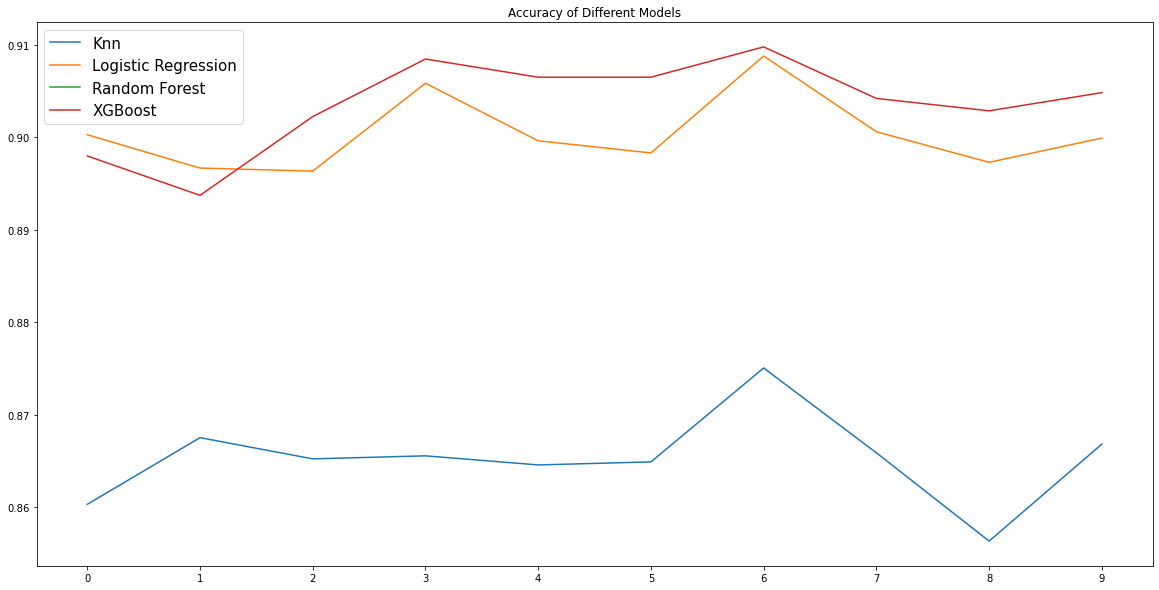

In [108]:
with warnings.catch_warnings(record=True):
    normalPlot = plt.figure(1)
    
    knnAccs = pd.Series(data = knnAccs)
    knnAccs.plot()
    
    lrAccs = pd.Series(data = lrAccs)
    lrAccs.plot()
    
    rfAccs = pd.Series(data = rfAccs)
    rfAccs.plot()
    
    xgbAccs = pd.Series(data = xgbAccs)
    xgbAccs.plot()
    
    plt.xticks(np.arange(0, splits, 1))
    plt.title("Accuracy of Different Models")
    plt.legend(loc="upper left", labels = ['Knn', 'Logistic Regression', 'Random Forest','XGBoost'], prop={'size': 15})
    
    normalPlot.show()

Given the performance shown in the figure above, it was clear that the scaled data

In [15]:
get_metrics_score(lrClfScaled, flag=True)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

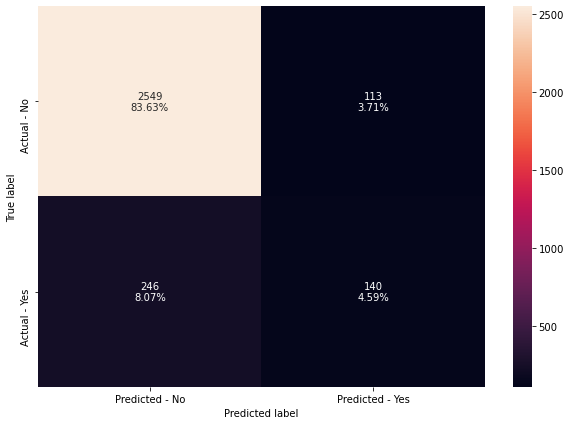

In [87]:
make_confusion_matrix(lrClf, yTest, xTestScaled, labels = ['no', 'yes'])

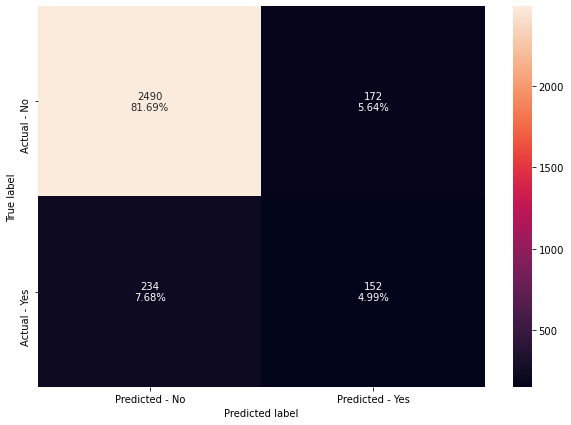

In [88]:
make_confusion_matrix(knn, yTest, xTestScaled, labels = ['no','yes'])

### Part 3

***Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!***

#### Random Forest

#### XGBoost

In [96]:
xgb = XGBClassifier(random_state=10, eval_metric='logloss')
xgb.fit(xTrain,yTrain)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['no' 'yes']

#### KNN

### Part 4

***Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.***

### Part 5

***Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.***

## Part 6

***Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.***

## Deployment

***How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?***

## Exceptional Work

You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?